# 特征选择

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import VarianceThreshold # 方差过滤
from sklearn.feature_selection import SelectKBest       # 选择特征，根据最佳特征数量选择
from sklearn.feature_selection import chi2              # 卡方过滤，分类的相关性过滤
from sklearn.feature_selection import f_classif         # F 检验，可以做回归、分类的线性相关性
from sklearn.feature_selection import mutual_info_classif # 互信息法，可以做回归、分类的相关性

from sklearn.feature_selection import SelectFromModel   # 从模型中选择

from sklearn.model_selection import cross_val_score

## Filter 过滤法

### 方差过滤

In [2]:
data = pd.read_csv('./data/digit_recognizor.csv')

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [9]:
X.shape

(42000, 784)

In [7]:
selector = VarianceThreshold()              #实例化，不填参数默认方差为0
X_var0 = selector.fit_transform(X)          #获取删除不合格特征之后的新特征矩阵,表示删除方差为0的特征
# x = VairanceThreshold().fit_transform(X)
X_var0.shape

(42000, 708)

In [11]:
#  X.var().values 方差值
_median = np.median(X.var().values)

# 强制保留一半的维度
X_fsvar = VarianceThreshold(_median).fit_transform(X)
X_fsvar.shape

(42000, 392)

### 相关性过滤

#### 卡方过滤

In [14]:
X_fschi = SelectKBest(chi2, k=300).fit_transform(X_fsvar, y)
X_fschi.shape

(42000, 300)

In [17]:
RFC = RandomForestClassifier

In [18]:
%%time
cross_val_score(RFC(n_estimators=10, random_state=100), X,y,cv=5).mean()

Wall time: 15.7 s


0.9364285714285716

In [19]:
%%time
cross_val_score(RFC(n_estimators=10, random_state=100), X_fschi,y,cv=5).mean()

Wall time: 10.9 s


0.9322380952380953

Wall time: 1min 44s


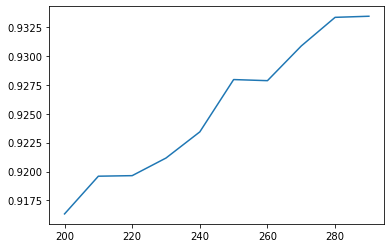

In [21]:
%%time
# 使用卡方检验挑选特征，比较准确度

scores = []
for i in range(200, 300, 10):
    X_fschi = SelectKBest(chi2, k=i).fit_transform(X_fsvar, y)
    score = cross_val_score(RFC(n_estimators=10, random_state=100), X_fschi,y,cv=5).mean()
    scores.append(score)
    
plt.plot(range(200, 300, 10), scores)

#### 显著性水平
* 一般使用 0.05

In [29]:
chi_values, p = chi2(X, y)

In [28]:
# 卡方检验，取p值大于0.05的特征
best_k = chi_values.shape[0] - (p>0.05).sum()

In [30]:
# F 检验
F, p = f_classif(X, y)
best_k_f = F.shape[0] - (p>0.05).sum()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57  82  83
  84  85 111 112 139 140 141 168 196 392 420 421 448 476 532 560 644 645
 671 672 673 699 700 701 727 728 729 730 731 754 755 756 757 758 759 760
 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [31]:
best_k_f

736

In [33]:
%%time
# 互信息过滤

result = mutual_info_classif(X, y)
k = result.shape[0]-sum(result <= 0)#当result>0时相关，为0时独立，为1时完全相关
k

Wall time: 6min 37s


685

## Embedded 嵌入法

* 让算法决定使用什么特征
* 算法选择和算法训练同时进行

In [35]:
estimator = RandomForestClassifier(n_estimators=10, random_state=100)
X_embedded = SelectFromModel(estimator, threshold=0.005).fit_transform(X, y) # 删除阈值小于 0.005 的特征

# estimator.fit(X,y).feature_importances_

In [37]:
X_embedded.shape

(42000, 51)

In [42]:
%%time

threshold = np.linspace(0, (estimator.fit(X,y).feature_importances_).max(), 20)
scores = []
for i in threshold:
    X_threshold = SelectFromModel(estimator, threshold=i).fit_transform(X, y)
    score = cross_val_score(estimator, X_threshold, y, cv=5).mean()
    scores.append(score)

Wall time: 2min 50s


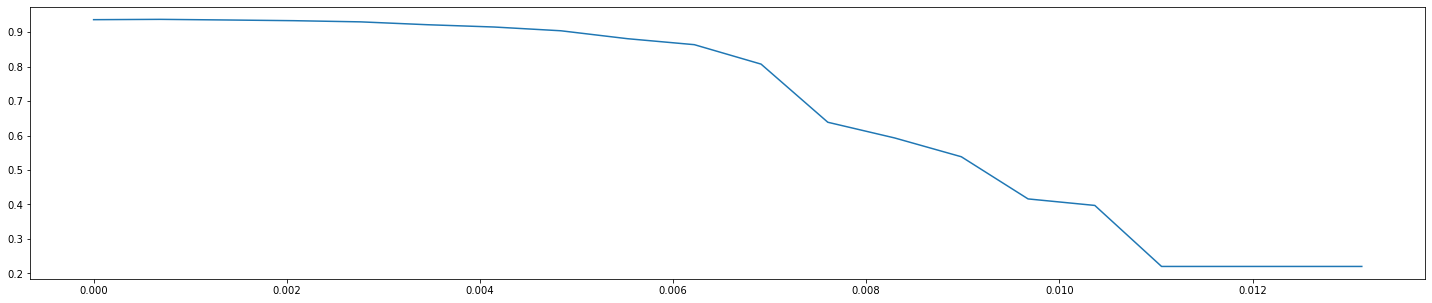

In [43]:
plt.figure(figsize=size=[25,5])
plt.plot(threshold, scores)